# Variant 1 - Self-Trained Embeddings - Tensor flow 2 Required

In [10]:
# Needed software - Tensorflow 2
!pip install pandasql
!pip install wordcloud
import pandasql as ps
import tensorflow as tf
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, SpatialDropout1D,Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.datasets import imdb
import tensorflow as tf
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import add,Lambda,Dense,subtract, Input, Dropout, LSTM, Activation,SimpleRNN,concatenate,Flatten,MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization,LayerNormalization
from tensorflow import keras


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


# Data Preparation

800


[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


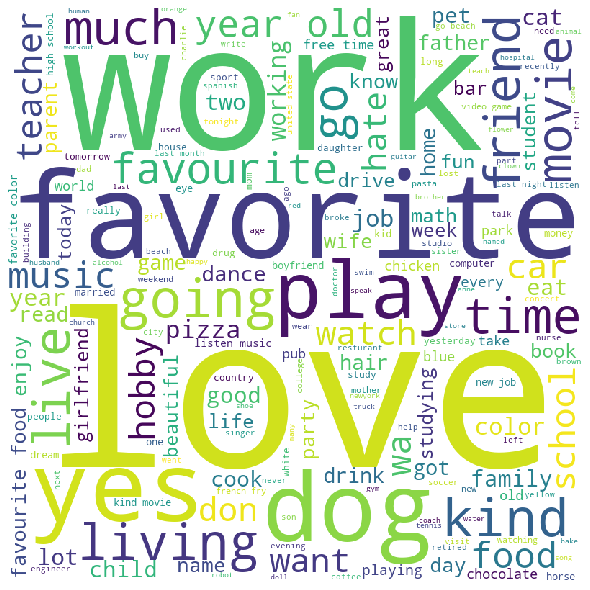

        word  frequency
0       love        116
1       work         71
2   favorite         51
3       kind         42
4       year         42
5      movie         38
6       food         37
7      music         36
8       live         35
9       time         35
10       dog         34
11     going         34
12      play         34
13    friend         33
14        go         32
15     color         30
16    living         30
17    school         30
18       job         29
19     watch         28


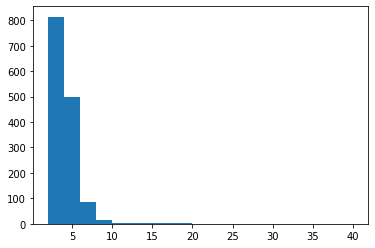

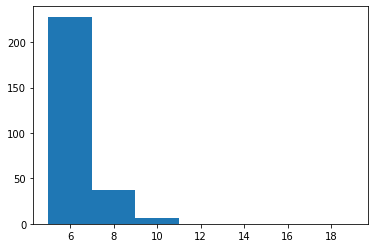

  confusion  cnt
0        no  418
1       yes  382


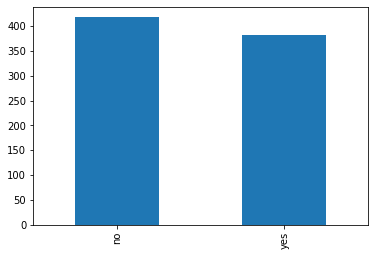

In [11]:
#Dataset load and give headers
X_Y_full = pd.read_excel('confusion_excel_800.xlsx', nrows = 800,sheet_name='Sheet1')
print(len(X_Y_full))
del X_Y_full['Unnamed: 1']
del X_Y_full['Unnamed: 3']
del X_Y_full['Unnamed: 5']
X_Y_full.columns = ['request','response','confusion']
X_Y_full = X_Y_full[X_Y_full['request'].notnull()]

#Lemmatization
import nltk
nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    listToStr = ' '.join(map(str, [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]))
    return listToStr
#df = pd.DataFrame(['this was cheesy', 'she likes these books', 'wow this is great'], columns=['text'])
X_Y_full['request'] = X_Y_full['request'].apply(lemmatize_text)
X_Y_full['response'] = X_Y_full['response'].apply(lemmatize_text)

#Stop words Removal
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.append("i'm")
stop.append("im")
stop.append("i")
X_Y_full['request']  = X_Y_full['request'].str.lower().str.strip()
X_Y_full['response']  = X_Y_full['response'].str.lower().str.strip()
X_Y_full['confusion'] = X_Y_full['confusion'].str.lower().str.strip()
X_Y_full['request'] = X_Y_full['request'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))
X_Y_full['response'] = X_Y_full['response'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))


# Data Splitting
train, validate, test = np.split(X_Y_full.sample(frac=1).reset_index(drop=True), [int(0.8*len(X_Y_full)), int(0.9*len(X_Y_full))])
from sklearn.model_selection import train_test_split
x_train_request = (train.request)
x_train_response = (train.response)
y_train = (train.confusion)
x_validate_request = (validate.request)
x_validate_response = (validate.response)
y_validate = (validate.confusion)
x_test_request = (test.request )
x_test_response = (test.response )
y_test = (test.confusion)

# Voicabulary building
frame_1 = ps.sqldf('select request,1 from X_Y_full')
frame_2 = ps.sqldf('select response,2 from X_Y_full')
frame_2.columns = frame_1.columns
frame_combined = pd.concat([frame_1, frame_2], ignore_index=True)
len(frame_combined)
frame_combined.columns = ['re','dummy'] 
results = set()
frame_combined['re'].str.lower().str.split().apply(results.update)
vocab = len(results)

# Word cloud on vocabulary
word_cloud = ps.sqldf('select re as CONTENT from frame_combined')
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
comment_words = '' 
stopwords = set(STOPWORDS) 
  

for val in word_cloud.CONTENT: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

#Tabular form of word cloud - top N frequencies
words_df = pd.concat([pd.Series(row['CONTENT'].split(' '))              
                    for _, row in word_cloud.iterrows()]).reset_index()
words_df.columns = ['num','word']
word_count = ps.sqldf('select * from (select word as word,count(*) as frequency from words_df where word not in (\'like\',\'favourite\')group by word) order by frequency desc limit 20')
print(word_count)

# Word Distribution outlier check
frame_combined['new_column'] = frame_combined['re'].str.count(' ') + 1
is_10 =  frame_combined['new_column'] < 10
from collections import Counter
frame_combined['word_cnt'] = frame_combined.re.apply(lambda x: len(x.split(' ')))
#Wider bins 2-40
ax = plt.hist(frame_combined['word_cnt'],bins = [2,4,6,8,10,20,40])
plt.show()
#close bins 5-20
ax = plt.hist(frame_combined['word_cnt'],bins = [5,7,9,11,13,15,17,19])
plt.show()
vocab = len(results)
maxLen = 10 # based on plot results

#Tokenise the sequences and give indices to them
import tensorflow as tf
from keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=vocab,filters='![0-9]"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower = False)
tokenizer.fit_on_texts(frame_combined['re'])

#Tokenise train test and validation
unique_vocab = len(tokenizer.word_index)
x_train_request = tokenizer.texts_to_sequences(x_train_request)
unique_vocab = len(tokenizer.word_index)
x_train_request = sequence.pad_sequences(x_train_request,padding='post', maxlen=maxLen)
x_test_request = tokenizer.texts_to_sequences(x_test_request)
x_test_request = sequence.pad_sequences(x_test_request,padding='post', maxlen=maxLen)
x_validate_request = tokenizer.texts_to_sequences(x_validate_request)
x_validate_request = sequence.pad_sequences(x_validate_request,padding='post', maxlen=maxLen)
x_train_response = tokenizer.texts_to_sequences(x_train_response)
x_train_response = sequence.pad_sequences(x_train_response,padding='post', maxlen=maxLen)
x_test_response = tokenizer.texts_to_sequences(x_test_response)
x_test_response = sequence.pad_sequences(x_test_response,padding='post', maxlen=maxLen)
x_validate_response = tokenizer.texts_to_sequences(x_validate_response)
x_validate_response = sequence.pad_sequences(x_validate_response,padding='post', maxlen=maxLen)
y_train_new = ps.sqldf("select case when lower(confusion)='yes' then 1 else 0 end as confusion_new from train")
y_train_new = np.asarray(y_train_new['confusion_new'])
y_test_new = ps.sqldf("select case when lower(confusion)='yes' then 1 else 0 end as confusion_new from test")
y_test_new = np.asarray(y_test_new['confusion_new'])
y_validation_new = ps.sqldf("select case when lower(confusion)='yes' then 1 else 0 end as confusion_new from validate")
y_validation_new = np.asarray(y_validation_new['confusion_new'])
x_train_req = np.asarray(x_train_request)
x_train_res = np.asarray(x_train_response)
x_validate_req = np.asarray(x_validate_request)
x_validate_res = np.asarray(x_validate_response)
x_test_req = np.asarray(x_test_request)
x_test_res = np.asarray(x_test_response)

# Data Balance Check
balance_check = ps.sqldf('select confusion,count(*) as cnt from X_Y_full group by confusion')
X_Y_full['confusion'].value_counts().plot(kind='bar')
print(balance_check)



# Modelling Variant 1

In [83]:
# model 1 - Self trained embeddings type training and hyper parameter tuning
print("Now building dual encoder lstm model...")

model = Sequential()
embedding_size=10
model.add(Embedding(unique_vocab+1,
                    embedding_size,
                    input_length=maxLen,batch_input_shape=[10, None]))
model.add(LayerNormalization())
#model.add(SpatialDropout1D(0.2))
model.add(LSTM(50,recurrent_dropout=0.4))
#model.summary()

#model.add(LSTM(50,return_sequences=False, stateful=True,recurrent_initializer='glorot_uniform'))
#model.add(Dense(100,activation='relu'))

# model.add(tf.keras.layers.LSTM(100,return_sequences=True,  stateful=True,recurrent_initializer='glorot_uniform'))
# model.add(tf.keras.layers.LSTM(100,return_sequences=False, stateful=True,recurrent_initializer='glorot_uniform'))
#dropout=0.3, recurrent_dropout=0.2
#model.add(Dropout(rate=0.35))
#model.add(Dense(1,activation='sigmoid'))
#model.summary()

context_input = Input(shape=(maxLen,), dtype='int32')
response_input = Input(shape=(maxLen,), dtype='int32')

context_branch = model(context_input)
response_branch = model(response_input)

minus_r2 = Lambda(lambda x: -x)(response_branch)
subtracted = add([context_branch,minus_r2])
squared = Lambda(lambda x: x)(subtracted)
root = Lambda(lambda x: abs(x))(squared)


#concatenated = layers.concatenate([context_branch, response_branch]) 
norm1 = LayerNormalization()(root)
#model.add(BatchNormalization())
dense_1 = Dense((20), activation = "relu") (norm1)
dropped = Dropout(rate=0.5)(dense_1)
norm2 = LayerNormalization()(dropped)
dense_2 = Dense((10), activation = "relu") (norm2)

out = Dense((1), activation = "sigmoid") (dense_2)

dual_encoder = Model([context_input, response_input], out)

#Loss Function # tried different values for learning_rate
from tensorflow.keras import optimizers
AD = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
dual_encoder.compile(optimizer=AD,
              loss='binary_crossentropy',
              metrics=[keras.metrics.Recall(),keras.metrics.Precision(),'accuracy'])


          


Now building dual encoder lstm model...


In [84]:
#Training 
hist = dual_encoder.fit([x_train_req,x_train_res], y_train_new,
          batch_size=10,
          epochs=50,verbose=1,validation_data=([x_validate_req,x_validate_res], y_validation_new))

Train on 640 samples, validate on 80 samples
Epoch 1/50
640/640 [==============================] - 27s 42ms/sample - loss: 0.7481 - recall_75: 0.4820 - precision_69: 0.4696 - acc: 0.4938 - val_loss: 0.6739 - val_recall_75: 0.6111 - val_precision_69: 0.5641 - val_acc: 0.6125
Epoch 2/50
640/640 [==============================] - 1s 2ms/sample - loss: 0.7278 - recall_75: 0.4656 - precision_69: 0.4765 - acc: 0.5016 - val_loss: 0.6781 - val_recall_75: 0.6944 - val_precision_69: 0.4902 - val_acc: 0.5375
Epoch 3/50
640/640 [==============================] - 1s 2ms/sample - loss: 0.7141 - recall_75: 0.4230 - precision_69: 0.4778 - acc: 0.5047 - val_loss: 0.6756 - val_recall_75: 0.5000 - val_precision_69: 0.5000 - val_acc: 0.5500
Epoch 4/50
640/640 [==============================] - 1s 2ms/sample - loss: 0.6998 - recall_75: 0.4295 - precision_69: 0.4834 - acc: 0.5094 - val_loss: 0.6995 - val_recall_75: 0.5833 - val_precision_69: 0.5385 - val_acc: 0.5875
Epoch 5/50
640/640 [=====================

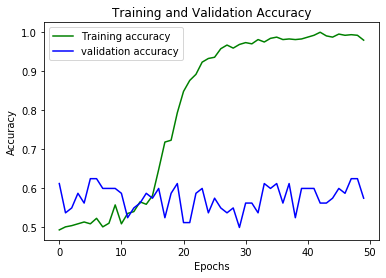

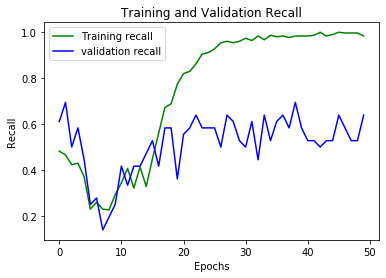

In [86]:
# Training and validation accuracy and recall growth through epochs
loss_train = hist.history[dual_encoder.metrics_names[3]]
loss_val = hist.history['val_'+dual_encoder.metrics_names[3]]
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


loss_train = hist.history[dual_encoder.metrics_names[1]]
loss_val = hist.history['val_'+dual_encoder.metrics_names[1]]
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training recall')
plt.plot(epochs, loss_val, 'b', label='validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()



In [85]:
# Initial validation
#loss, acc = model1.evaluate([x_validate_req,x_validate_res], y_validation_new)
#print(acc)
dual_encoder.evaluate([x_validate_req,x_validate_res], y_validation_new,use_multiprocessing = False,batch_size = 10)

#loss, acc = model1.evaluate([x_test_req,x_test_res], y_test_new)
#print(acc)
dual_encoder.evaluate([x_test_req,x_test_res], y_test_new,use_multiprocessing = False,batch_size = 10)

80/80 [==============================] - 0s 483us/sample - loss: 3.5167 - recall_75: 0.6341 - precision_69: 0.5652 - acc: 0.5625


[3.516669288277626, 0.63414633, 0.5652174, 0.5625]

# Evaluation of Variant 1 - 10 Fold Validation

In [77]:
# Preparation for 10 fold validation
inputs_req = np.concatenate((x_train_req, x_validate_req, x_test_req), axis=0)
inputs_res = np.concatenate((x_train_res, x_validate_res, x_test_res), axis=0)
targets = np.concatenate((y_train_new, y_validation_new,y_test_new), axis=0)

from sklearn.model_selection import KFold
import numpy as np
num_folds = 10

# Define per-fold score containers <-- these are new
acc_per_fold_1 = []
loss_per_fold_1 = []
rec_per_fold_1 = []
pre_per_fold_1 = []

from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers

kfold = KFold(n_splits=num_folds, shuffle=False)

fold_no = 1
for train, test in kfold.split(inputs_req,inputs_res, targets):
    model = Sequential()
    embedding_size=10
    model.add(Embedding(unique_vocab+1,
                        embedding_size,
                        input_length=maxLen,batch_input_shape=[10, None]))
    model.add(LayerNormalization())
    #model.add(SpatialDropout1D(0.2))
    model.add(LSTM(50,recurrent_dropout=0.3))
    #model.summary()

    #model.add(LSTM(50,return_sequences=False, stateful=True,recurrent_initializer='glorot_uniform'))
    #model.add(Dense(100,activation='relu'))

    # model.add(tf.keras.layers.LSTM(100,return_sequences=True,  stateful=True,recurrent_initializer='glorot_uniform'))
    # model.add(tf.keras.layers.LSTM(100,return_sequences=False, stateful=True,recurrent_initializer='glorot_uniform'))
    #dropout=0.3, recurrent_dropout=0.2
    #model.add(Dropout(rate=0.35))
    #model.add(Dense(1,activation='sigmoid'))
    #model.summary()

    context_input = Input(shape=(maxLen,), dtype='int32')
    response_input = Input(shape=(maxLen,), dtype='int32')

    context_branch = model(context_input)
    response_branch = model(response_input)

    minus_r2 = Lambda(lambda x: -x)(response_branch)
    subtracted = add([context_branch,minus_r2])
    squared = Lambda(lambda x: x)(subtracted)
    root = Lambda(lambda x: abs(x))(squared)


    #concatenated = layers.concatenate([context_branch, response_branch]) 
    norm1 = LayerNormalization()(root)
    #model.add(BatchNormalization())
    dense_1 = Dense((20), activation = "relu") (norm1)
    dropped = Dropout(rate=0.5)(dense_1)
    norm2 = LayerNormalization()(dense_1)
    dense_2 = Dense((10), activation = "relu") (norm2)

    out = Dense((1), activation = "sigmoid") (dense_2)

    dual_encoder = Model([context_input, response_input], out)
    
    #Loss Function # tried different values for learning_rate
    #from tensorflow.keras import optimizers
    AD = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    dual_encoder.compile(optimizer=AD,
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.Recall(),keras.metrics.Precision(),'accuracy'])
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    hist = dual_encoder.fit([inputs_req[train],inputs_res[train]], targets[train],
          batch_size=10,
          epochs=20)


          
    #model.save('Part_A_Best_2_50k_SimpleRNN.h5')  

    #Generate generalization metrics
    scores = dual_encoder.evaluate([inputs_req[test],inputs_res[test]], targets[test], verbose=0,batch_size=10)
    print(f'Score for fold {fold_no}: {dual_encoder.metrics_names[0]} of {scores[0]}; {dual_encoder.metrics_names[1]} of {scores[1]*100}%; {dual_encoder.metrics_names[2]} of {scores[2]*100}%; {dual_encoder.metrics_names[3]} of {scores[3]*100}%')
    acc_per_fold_1.append(scores[1] * 100)
    loss_per_fold_1.append(scores[0])
    rec_per_fold_1.append(scores[2] * 100)
    pre_per_fold_1.append(scores[3] * 100)

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold_1)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold_1[i]} - Accuracy: {acc_per_fold_1[i]}% - Recall: {rec_per_fold_1[i]}% - Precision: {pre_per_fold_1[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold_1)} (+- {np.std(acc_per_fold_1)})')
print(f'> Recall: {np.mean(rec_per_fold_1)} (+- {np.std(rec_per_fold_1)})')
print(f'> Precision: {np.mean(pre_per_fold_1)} (+- {np.std(pre_per_fold_1)})')
print(f'> Loss: {np.mean(loss_per_fold_1)}')
print('------------------------------------------------------------------------')






------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
720/720 [==============================] - 7s 9ms/sample - loss: 0.7367 - recall_64: 0.1994 - precision_58: 0.4891 - acc: 0.5292
Epoch 2/20
720/720 [==============================] - 1s 2ms/sample - loss: 0.6940 - recall_64: 0.4702 - precision_58: 0.5016 - acc: 0.5347
Epoch 3/20
720/720 [==============================] - 1s 2ms/sample - loss: 0.6830 - recall_64: 0.3423 - precision_58: 0.4792 - acc: 0.5194
Epoch 4/20
720/720 [==============================] - 1s 2ms/sample - loss: 0.6813 - recall_64: 0.5119 - precision_58: 0.5309 - acc: 0.5611
Epoch 5/20
720/720 [==============================] - 1s 2ms/sample - loss: 0.6584 - recall_64: 0.5149 - precision_58: 0.5986 - acc: 0.6125
Epoch 6/20
720/720 [==============================] - 1s 2ms/sample - loss: 0.6152 - recall_64: 0.6488 - precision_58: 0.6141 - acc: 0.6458
Epoch 7/20
720/720 [==============================] - 1s 2ms/sa

In [87]:
# List of 10 accuracies and recall scores
acc_per_fold_1_round = [round(num, 2) for num in acc_per_fold_1]
print(acc_per_fold_1_round)
print(np.mean(acc_per_fold_1))

rec_per_fold_1_round = [round(num, 2) for num in rec_per_fold_1]
print(rec_per_fold_1_round)
print(np.mean(rec_per_fold_1))

# #f1_score =(np.multiply(2,np.multiply(pre_per_fold_1,rec_per_fold_1))/np.add(pre_per_fold_1,rec_per_fold_1))
# print(f1_score)
# print(np.mean(f1_score))




[56.52, 53.66, 71.43, 66.67, 63.89, 59.46, 51.35, 70.0, 52.78, 48.78]
59.45334851741791
[74.29, 64.71, 67.57, 68.75, 51.11, 59.46, 59.38, 65.12, 55.88, 76.92]
64.31764543056488


#   Variant 3 - Glove Pre-trained embeddings type  

In [ ]:
# Downloading the glove embeddings
#!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
#!unzip -q glove.840B.300d.zip

In [13]:
# Initialising glove
import os
import pathlib
embeddings_index = {}
#with open(glove_file, 'r') as f:
with open("glove.840B.300d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.


Found 2195884 word vectors.


In [16]:
# looking up on glove for the vocabulary and build the embedding matrix
num_tokens = unique_vocab + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    #print(word)
    embedding_vector = embeddings_index.get(word)
    #print(len(embedding_vector) == 0)
    if word in embeddings_index and len(embedding_vector) != 0:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        #print(len(embedding_vector))
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 1353 words (30 misses)


# Modelling Variant 3 

In [90]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

int_sequences_input1 = keras.Input(shape=(None,), dtype="int64")
int_sequences_input2 = keras.Input(shape=(None,), dtype="int64")

embedded_sequences1 = embedding_layer(int_sequences_input1)
X = LSTM(units = 256)(embedded_sequences1)



embedded_sequences2 = embedding_layer(int_sequences_input2)
X1 = LSTM(units = 256)(embedded_sequences2)


minus_r2 = Lambda(lambda x: -x)(X1)
subtracted = add([X,minus_r2])
squared = Lambda(lambda x: x**2)(subtracted)
root = Lambda(lambda x: x**1/2)(squared)

#normal3 = LayerNormalization()(root)

B = Dense(units = 256)(root)

normal3 = BatchNormalization()(B)

act = Activation("relu")(normal3)

f = Dense(units = 100)(act)

normal4 = BatchNormalization()(f)

act1 = Activation("relu")(normal4)

d = Dense(units = 1)(act1)
#norm3 = LayerNormalization()(d)
    # Add a softmax activation
C = Activation("sigmoid")(d)

model1 = keras.Model([int_sequences_input1,int_sequences_input2], C)
#model1.summary()


from tensorflow.keras import optimizers
#AD = optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')
AD = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#AD = optimizers.RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=True)#  RMSprop

model1.compile(optimizer=AD,
              loss='binary_crossentropy',
              metrics=[keras.metrics.Recall(),'accuracy'])


history = model1.fit([x_train_req,x_train_res], y_train_new,
      batch_size=10,
      epochs=20,verbose=1,validation_data=([x_validate_req,x_validate_res], y_validation_new)
      )


Train on 640 samples, validate on 80 samples
Epoch 1/20
640/640 [==============================] - 27s 42ms/sample - loss: 0.7028 - recall_76: 0.8033 - acc: 0.5266 - val_loss: 0.6930 - val_recall_76: 0.0000e+00 - val_acc: 0.5500
Epoch 2/20
640/640 [==============================] - 2s 3ms/sample - loss: 0.5766 - recall_76: 0.7443 - acc: 0.7016 - val_loss: 0.6928 - val_recall_76: 0.0000e+00 - val_acc: 0.5375
Epoch 3/20
640/640 [==============================] - 2s 3ms/sample - loss: 0.5127 - recall_76: 0.8131 - acc: 0.7641 - val_loss: 0.6925 - val_recall_76: 0.5833 - val_acc: 0.5750
Epoch 4/20
640/640 [==============================] - 2s 3ms/sample - loss: 0.4459 - recall_76: 0.8197 - acc: 0.8047 - val_loss: 0.6902 - val_recall_76: 0.3889 - val_acc: 0.6000
Epoch 5/20
640/640 [==============================] - 2s 3ms/sample - loss: 0.3931 - recall_76: 0.8197 - acc: 0.8406 - val_loss: 0.6835 - val_recall_76: 0.3333 - val_acc: 0.6000
Epoch 6/20
640/640 [==============================] - 2

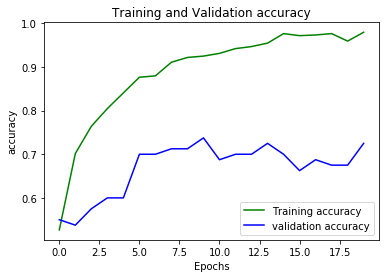

In [91]:
loss_train = history.history[model1.metrics_names[2]]
loss_val = history.history['val_'+model1.metrics_names[2]]
epochs = range(0,20)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

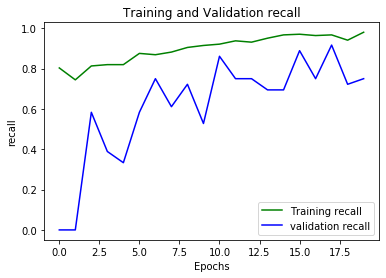

In [92]:
loss_train = history.history[model1.metrics_names[1]]
loss_val = history.history['val_'+model1.metrics_names[1]]
epochs = range(0,20)
plt.plot(epochs, loss_train, 'g', label='Training recall')
plt.plot(epochs, loss_val, 'b', label='validation recall')
plt.title('Training and Validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()
plt.show()

In [93]:

#loss, acc = model1.evaluate([x_validate_req,x_validate_res], y_validation_new)
#print(acc)
model1.evaluate([x_validate_req,x_validate_res], y_validation_new)

#loss, acc = model1.evaluate([x_test_req,x_test_res], y_test_new)
#print(acc)
model1.evaluate([x_test_req,x_test_res], y_test_new)

80/80 [==============================] - 0s 307us/sample - loss: 0.8552 - recall_76: 0.6341 - acc: 0.7000


[0.855243468284607, 0.63414633, 0.7]

# Evaluation of Variant 3 - 10 Fold Validation

In [98]:
inputs_req = np.concatenate((x_train_req, x_validate_req, x_test_req), axis=0)
inputs_res = np.concatenate((x_train_res, x_validate_res, x_test_res), axis=0)
targets = np.concatenate((y_train_new, y_validation_new,y_test_new), axis=0)

from sklearn.model_selection import KFold
import numpy as np
num_folds = 10

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []
rec_per_fold = []
kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(inputs_req,inputs_res, targets):
    int_sequences_input1 = keras.Input(shape=(None,), dtype="int64")
    int_sequences_input2 = keras.Input(shape=(None,), dtype="int64")

    embedded_sequences1 = embedding_layer(int_sequences_input1)
    X = LSTM(units = 100)(embedded_sequences1)



    embedded_sequences2 = embedding_layer(int_sequences_input2)
    X1 = LSTM(units = 100)(embedded_sequences2)


    minus_r2 = Lambda(lambda x: -x)(X1)
    subtracted = add([X,minus_r2])
    squared = Lambda(lambda x: x**2)(subtracted)
    root = Lambda(lambda x: x**1/2)(squared)

    #root = subtract([X,X1])

    #normal3 = LayerNormalization()(root)

    B = Dense(units = 256)(root)

    normal3 = BatchNormalization()(B)

    act = Activation("relu")(normal3)

    f = Dense(units = 100)(act)

    normal4 = BatchNormalization()(f)

    act1 = Activation("relu")(normal4)

    d = Dense(units = 1)(act1)
    #norm3 = LayerNormalization()(d)
        # Add a softmax activation
    C = Activation("sigmoid")(d)

    model1 = keras.Model([int_sequences_input1,int_sequences_input2], C)
    #model1.summary()
    
    
    #AD = optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')
    AD = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    #AD = optimizers.RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=True)#  RMSprop

    model1.compile(optimizer=AD,
                  loss='binary_crossentropy',
                  metrics=['accuracy',keras.metrics.Recall()])
    
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model1.fit([inputs_req[train],inputs_res[train]], targets[train],
                  batch_size=10,
                  epochs=30 )

    #Generate generalization metrics
    scores = model1.evaluate([inputs_req[test],inputs_res[test]], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%; {model1.metrics_names[2]} of {scores[2]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    rec_per_fold.append(scores[2] * 100)

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - Recall: {rec_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Recall: {np.mean(rec_per_fold)} (+- {np.std(rec_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')






------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
720/720 [==============================] - 9s 13ms/sample - loss: 0.7090 - acc: 0.5208 - recall_92: 0.6329
Epoch 2/30
720/720 [==============================] - 1s 2ms/sample - loss: 0.6235 - acc: 0.6431 - recall_92: 0.6185
Epoch 3/30
720/720 [==============================] - 1s 2ms/sample - loss: 0.5697 - acc: 0.7250 - recall_92: 0.7312
Epoch 4/30
720/720 [==============================] - 1s 2ms/sample - loss: 0.5372 - acc: 0.7458 - recall_92: 0.7168
Epoch 5/30
720/720 [==============================] - 1s 2ms/sample - loss: 0.4890 - acc: 0.7569 - recall_92: 0.7601
Epoch 6/30
720/720 [==============================] - 1s 2ms/sample - loss: 0.4486 - acc: 0.8069 - recall_92: 0.7919
Epoch 7/30
720/720 [==============================] - 1s 2ms/sample - loss: 0.4101 - acc: 0.8333 - recall_92: 0.7890
Epoch 8/30
720/720 [==============================] - 1s 2ms/sample - loss: 0.3664 

In [99]:
# List of 10 accuracies
acc_per_fold

round_to_tenths = [round(num, 2) for num in acc_per_fold]
print(round_to_tenths)
np.mean(round_to_tenths)

[61.25, 75.0, 67.5, 78.75, 67.5, 68.75, 71.25, 65.0, 73.75, 68.75]


69.75

In [100]:
# List of 10 recall scores
rec_per_fold

round_to_tenths_rec = [round(num, 2) for num in rec_per_fold]
print(round_to_tenths_rec)
np.mean(round_to_tenths_rec)

[52.78, 72.22, 62.5, 71.43, 64.86, 59.09, 66.67, 60.53, 69.7, 61.76]


64.15400000000001